In [1]:
from cobra import io
from cobra.core import Metabolite
from cobra import flux_analysis
from Functions import *
from IPython import display
import logging
logging.basicConfig()
logger = logging.getLogger('logger')

#import sbml file
fname = "./../plantcoremetabolism-model/PlantCoreMetabolism_v2_1_0.xml"
model = io.sbml.read_sbml_model(fname)
display.clear_output()

#change Biomass_tx to Protein_biomass
rxn = model.reactions.get_by_id("Biomass_tx")
rxn.id = "Protein_biomass_tx"
for met in ["K_b","Ca_b","Mg_b"]:
    met  = model.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})



In [2]:
#remove charged state of PGPs since they are minor (0.03)
removeSpecificMetChargedState(model,["aL_1_PHOSPHATIDYL_GLYCEROL_P_p","aL_1_PHOSPHATIDYL_GLYCEROL_P_m"])
model.reactions.LPG_biosynthesis_c.reaction

'L_1_PHOSPHATIDYL_GLYCEROL_P_p + WATER_c --> Fatty_Acids_c + Lysophosphatidylglycerols_r + PROTON_c'

In [3]:
import pandas as pd
biomass = pd.DataFrame(data={"":["sSUCROSE_b","GLC_c","FRU_c","Starch_b","Cellulose_b","Xylan_b",
                                 "L_PHOSPHATIDATE_p","PHOSPHATIDYL_CHOLINE_r",
                                 "L_1_PHOSPHATIDYL_ETHANOLAMINE_r","DIACYLGLYCEROL_p",
                                 "Galactosyl_galactosyl_diacyl_glycerols_p",
                                 "D_Galactosyl_12_diacyl_glycerols_p","2_Lysophosphatidylcholines_r",
                                 "Lysophosphatidylglycerols_r","Triacylglycerols_p",
                                 "L_1_PHOSPHATIDYL_GLYCEROL_p","L_1_phosphatidyl_inositols_r",
                                 "SULFOQUINOVOSYLDIACYLGLYCEROL_p","Protein_b",
                                 "sMAL_b","sCIT_b","sFUM_b","ARG_c","HIS_c","LYS_c","sASP_b",
                                 "sGLU_b","sSER_b","THR_c","ASN_c","sGLN_b","CYS_c",
                                 "GLY_c","PRO_c","sALA_b","VAL_c","ILE_c","LEU_c",
                                 "MET_c","PHE_c","TYR_c","TRP_c","sGABA_b","PALMITATE_p",
                                 "CPD_9245_p","CPD_17412_p","CPD_17291_p","STEARIC_ACID_p",
                                 "OLEATE_CPD_p","Octadecadienoate_p","LINOLENIC_ACID_p",
                                 "ARACHIDIC_ACID_p","CPD_16709_p","DOCOSANOATE_p",
                                 "SUC_c","FUM_c","MAL_c","CIS_ACONITATE_c","CIT_c","MYO_INOSITOL_c",
                                 "pHIS_b","pILE_b","pTHR_b","pARG_b","pASN_b","pGLU_b","pPHE_b",
                                 "pGLN_b","pTYR_b","pMET_b","pASP_b","pVAL_b","pLYS_b","pSER_b",
                                 "pGLY_b","pALA_b","pLEU_b","pPRO_b","pCYS_b","pTRP_b"],
                             "type":[""]*80,
                             "leaf":[0.0]*80,"stem":[0.0]*80,"root":[0.0]*80,"seed":[0.0]*80,},dtype="float64")
biomass = biomass.set_index("")
for i in ["pHIS_b","pILE_b","pTHR_b","pARG_b","pASN_b","pGLU_b","pPHE_b","pGLN_b","pTYR_b","pMET_b",
          "pASP_b","pVAL_b","pLYS_b","pSER_b","pGLY_b","pALA_b","pLEU_b","pPRO_b","pCYS_b","pTRP_b"]:
    biomass.at[i,"type"]="protein"
for i in ["PALMITATE_p","CPD_9245_p","CPD_17412_p","CPD_17291_p","STEARIC_ACID_p",
          "OLEATE_CPD_p","Octadecadienoate_p","LINOLENIC_ACID_p",
          "ARACHIDIC_ACID_p","CPD_16709_p","DOCOSANOATE_p"]:
    biomass.at[i,"type"]="fattyacid"
biomass

,type,leaf,stem,root,seed
,,,,,
sSUCROSE_b,,0.0,0.0,0.0,0.0
GLC_c,,0.0,0.0,0.0,0.0
FRU_c,,0.0,0.0,0.0,0.0
Starch_b,,0.0,0.0,0.0,0.0
Cellulose_b,,0.0,0.0,0.0,0.0
...,...,...,...,...,...
pALA_b,protein,0.0,0.0,0.0,0.0
pLEU_b,protein,0.0,0.0,0.0,0.0
pPRO_b,protein,0.0,0.0,0.0,0.0


### Leaf

Data extracted from Allwood et al 2015 Figure 1, was used to identify age of mature photosynthetic cells

<img src="references/Screenshot_20190710_102223.png">


Given that the mesophyll-cell-number-per-gram-FW stabilizes 40+ mm away from leaf base, cells are fully expanded in this region of the leaf

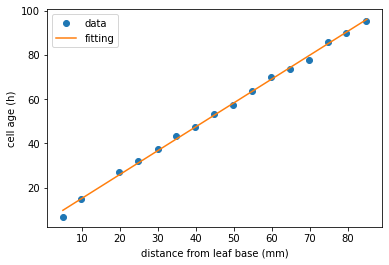

In [4]:
df_age_dist = pd.DataFrame(data={"1- distance from leaf base (mm)":[4.90932322908728,9.81901468871633,
                                                                 19.8310558274325,24.8076179534483,
                                                                 29.9084947103683,34.8212793065482,
                                                                 39.6748524316104,44.7119516586945,
                                                                 49.8770478221005,54.6650759107262,
                                                                 59.7643324532624,64.8049666935475,
                                                                 69.7206971340617,74.6925459091428,
                                                                 79.6084236418737,84.6469957911249,],
                                "2- cell age (h)":[6.79783038564788,14.7759133038013,27.0455022480475,
                                                32.0926173458679,37.3297394032456,43.3220286557008,
                                                47.3280823658076,53.51037857782,57.5186416711775,
                                                63.6046087734609,69.8819084652519,73.7947262021807,
                                                77.8957833920661,85.9688697899981,89.9753653767551,
                                                95.2120455574826]})
def cellAgefromDistancefromLeafBase(x,m,c):
    y = (m*x)+c
    return y

from scipy.optimize import curve_fit
popt_cellAge, pcov_cellAge = curve_fit(cellAgefromDistancefromLeafBase, \
                                       df_age_dist["1- distance from leaf base (mm)"], \
                                       df_age_dist["2- cell age (h)"],method="lm")

xlist = list()
ylist = list()
for i in range(5,95,10):
    i=float(i)
    xlist.append(i)
    ylist.append(cellAgefromDistancefromLeafBase(i,*popt_cellAge))

import matplotlib.pyplot as py
py.plot(df_age_dist["1- distance from leaf base (mm)"],df_age_dist["2- cell age (h)"],"o",label="data")
py.plot(xlist,ylist,"-",label="fitting")
py.xlabel("distance from leaf base (mm)")
py.ylabel("cell age (h)")
py.legend()
py.show()

Extracting data from Allwood et al 2015 Figure 3

<img src="references/Screenshot_20190710_111129.png">

In [5]:
df_content_1 = pd.DataFrame(data={"1- cell age (h)":[10.7692307692308,21.7751479289941,31.8343195266272,
                                                     41.8343195266272,51.8343195266272,61.7751479289941,
                                                     71.8343195266272,81.8343195266272,91.8934911242603],
                                "2- soluble CHO (mg/gFW)":[11,9.78947368421052,5.52631578947369,3.47368421052631,
                                                        3.10526315789473,2.99999999999999,4.31578947368421,
                                                        5.94736842105263,6.78947368421052],
                                 "3- insoluble CHO (mg/gFW)":[3.8515254521801,5.61828024675814,6.5047631037811,
                                                           5.37722942632925,4.76016618406144,4.02962776448865,
                                                           3.52603969952579,3.64673297242856,3.6254144110118],
                                 "4- protein concentration (mg/gFW)":[78.2456140350878,34.7368421052633,
                                                                   38.9473684210529,45.6140350877195,
                                                                   49.1228070175441,57.5438596491231,
                                                                   59.6491228070178,60.3508771929828,
                                                                   70.526315789474],
                                 "5- amino acid (umol/gFW)":[62.8169014084507,27.8873239436621,23.6619718309861,
                                                          22.5352112676059,21.1267605633804,23.6619718309861,
                                                          28.4507042253523,30.985915492958,40.8450704225355]})
df_content_1

,1- cell age (h),2- soluble CHO (mg/gFW),3- insoluble CHO (mg/gFW),4- protein concentration (mg/gFW),5- amino acid (umol/gFW)
0,10.769231,11.000000,3.851525,78.245614,62.816901
1,21.775148,9.789474,5.618280,34.736842,27.887324
2,31.834320,5.526316,6.504763,38.947368,23.661972
3,41.834320,3.473684,5.377229,45.614035,22.535211
4,51.834320,3.105263,4.760166,49.122807,21.126761
5,61.775148,3.000000,4.029628,57.543860,23.661972
6,71.834320,4.315789,3.526040,59.649123,28.450704
7,81.834320,5.947368,3.646733,60.350877,30.985915
8,91.893491,6.789474,3.625414,70.526316,40.845070


FW/DW ratio was estimated from Hu et al 2006

<img src="references/Screenshot_20190711_085710.png" height=50% width=50%>

In [6]:
df_FW_DW = pd.DataFrame(data={"Blade FW(g)":[0.2609523809523799,0.28761904761904644],
                              "Blade DW(g)":[0.046863468634686364,0.05409594095940953]})
df_FW_DW["FW/DW"]=df_FW_DW["Blade FW(g)"]/df_FW_DW["Blade DW(g)"]
print(df_FW_DW)
print("Average FW/DW = "+str(sum(df_FW_DW["FW/DW"])/len(df_FW_DW["FW/DW"])))

   Blade FW(g)  Blade DW(g)     FW/DW
0     0.260952     0.046863  5.568354
1     0.287619     0.054096  5.316832
Average FW/DW = 5.442593141068806


In [7]:
list1 = list(df_content_1["2- soluble CHO (mg/gFW)"]*5.44259314107)
list2 = list(df_content_1["3- insoluble CHO (mg/gFW)"]*5.44259314107)
list3 = list(df_content_1["4- protein concentration (mg/gFW)"]*5.44259314107)
list4 = list(df_content_1["5- amino acid (umol/gFW)"]*5.44259314107)

df_content_1_std = pd.DataFrame(data={"1- cell age (h)":df_content_1["1- cell age (h)"],
                                      "2- soluble CHO (mg/gDW)":list1,
                                      "3- insoluble CHO (mg/gDW)":list2,
                                      "4- protein concentration (mg/gDW)":list3,
                                      "5- amino acid (umol/gDW)":list4})
df_content_1_std

,1- cell age (h),2- soluble CHO (mg/gDW),3- insoluble CHO (mg/gDW),4- protein concentration (mg/gDW),5- amino acid (umol/gDW)
0,10.769231,59.868525,20.962286,425.859042,341.886837
1,21.775148,53.280122,30.578014,189.058499,151.779358
2,31.834320,30.077488,35.402779,211.974680,128.782486
3,41.834320,18.905850,29.266072,248.258635,122.649986
4,51.834320,16.900684,25.907648,267.355453,114.984362
5,61.775148,16.327779,21.931624,313.187816,128.782486
6,71.834320,23.489086,19.190799,324.645907,154.845608
7,81.834320,32.369107,19.847684,328.465270,168.643731
8,91.893491,36.952343,19.731656,383.846043,222.303100


Extracting data from Shi et al 2016 Figure 4

<img src="references/Screenshot_20190710_115400.png">

In [8]:
time = 30*24
print("30 DPA in hours = "+str(time))
df_content_2 = pd.DataFrame(data={"DPA":[15,15,15,15,20,20,20,20,25,25,25,25,30,30,30,30],
                                  "sucrose content (mg/gDW)":[10.4865764650646,14.2319347816808,
                                                              47.4902898117717,57.977293098297,
                                                              19.7754919117333,19.1762345810748,
                                                              53.3339024286141,62.7722053864868,
                                                              84.9447266208545,78.3537496265312,
                                                              23.970720047804,14.2332152460626,
                                                              12.2864825643433,11.3875965683554,
                                                              2.99799393913526,1.35003627982414]})
df_content_2["DPA"]=df_content_2["DPA"]*24
df_content_2

30 DPA in hours = 720


,DPA,sucrose content (mg/gDW)
0,360,10.486576
1,360,14.231935
2,360,47.490290
3,360,57.977293
4,480,19.775492
5,480,19.176235
6,480,53.333902
7,480,62.772205
8,600,84.944727
9,600,78.353750


##### Data for wheat sample analysis. Thanks to Penny Tricker and Pedro
Starch data found here: Onedrive > FFAR > Soy and wheat biomass content > Wheat > Wheat_lipid 


x nmol/mL/gDW = 100x nmol/gDW since 100mL was collected from 1gDW of sample.

In [9]:
df_ex_wheat_fattyacids = pd.read_csv("C:\\Users\\sanus\\Downloads\\Wheat_data\\Wheat_lipid\\Wheat_Lipids_processed.csv")
df_ex_wheat_fattyacids

,Sample,"Decanoic acid, methyl ester (C10:0)","Dodecanoic acid, methyl ester (C12:0)","Tridecanoic acid, methyl ester (C13:0)",Methyl myristoleate (C14:1),Methyl tetradecanoate (C14:0),"Pentadecanoic acid, methyl ester (C15:0)","9-Hexadecenoic acid, methyl ester, (Z)- (C16:1)","Hexadecanoic acid, methyl ester (C16:0)","Heptadecanoic acid, methyl ester (C17:0)","9,12-Octadecadienoic acid (Z,Z)-, methyl ester (C18:2)","9-Octadecenoic acid, methyl ester, (E)-Elaidic acid (C18:1)","9-Octadecenoic acid (Z)-, methyl ester-Oleic acid (C18:1)",Methyl stearate (C18:0),"cis-13-Eicosenoic acid, methyl ester-(cis-11-Eicosenoate) (C20:1)","Eicosanoic acid, methyl ester (C20:0)","13-Docosenoic acid, methyl ester (C22:1)","Docosanoic acid, methyl ester (C22:0)"
0,L3,0.283036,0.082762,0.001400,0.007805,0.105313,0.005737,0.389037,9.227581,0.046643,0.964757,0.026809,0.201814,2.386881,0.002399,0.075325,0.002281,0.115025
1,L4,0.257482,0.081367,0.002765,0.020698,0.166033,0.033936,1.134529,8.472354,0.073910,1.432149,0.040439,0.306357,2.925987,0.008618,0.132105,0.005258,0.387401
2,L5,0.088505,0.125981,0.003096,0.017525,0.191951,0.026259,1.722191,5.572568,0.056393,1.317219,0.052047,0.391848,1.249498,0.013378,0.136474,0.003518,0.357847
3,L8,0.171492,0.191432,0.006757,0.027352,0.342052,0.063938,3.730500,12.704155,0.139848,19.300420,0.142164,1.070315,3.547982,0.029466,0.308196,0.010714,0.698084
4,L9,0.159040,0.112662,0.003732,0.028171,0.203570,0.028677,1.735197,8.200342,0.071831,1.496393,0.053674,0.404100,2.699995,0.008666,0.144470,0.007030,0.294197
5,L11,0.259615,0.102032,0.004143,0.042882,0.174237,0.021987,1.189042,7.003642,0.083210,1.725953,0.026756,0.201443,2.062003,0.006559,0.170453,0.006943,0.397496
6,L12,0.133092,0.151000,0.003449,0.011912,0.197591,0.021485,1.474874,4.934404,0.052329,1.198274,0.017789,0.133930,0.261673,0.020178,0.057302,0.004448,0.080824
7,L16,0.220495,0.125304,0.006754,0.202544,0.343583,0.034598,1.863314,10.034937,0.082308,1.120993,0.044827,0.337491,3.536433,0.007211,0.195654,0.009876,0.405877
8,L19,0.131899,0.188981,0.006040,0.022372,0.258192,0.033893,2.523373,8.467322,0.086751,2.290330,0.036352,0.273683,1.606488,0.030486,0.144478,0.007231,0.406393
9,L20,0.199032,0.135408,0.005170,0.021881,0.268112,0.033183,2.169771,9.085528,0.061562,2.411094,0.087506,0.659356,2.551690,0.013833,0.165558,0.007872,0.407158


In [10]:
df_ex_wheat_fattyacids_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_fattyacids.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_fattyacids[df_ex_wheat_fattyacids["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_fattyacids_processed[col]=tempList

df_ex_wheat_fattyacids_processed



,sample,"Decanoic acid, methyl ester (C10:0)","Dodecanoic acid, methyl ester (C12:0)","Tridecanoic acid, methyl ester (C13:0)",Methyl myristoleate (C14:1),Methyl tetradecanoate (C14:0),"Pentadecanoic acid, methyl ester (C15:0)","9-Hexadecenoic acid, methyl ester, (Z)- (C16:1)","Hexadecanoic acid, methyl ester (C16:0)","Heptadecanoic acid, methyl ester (C17:0)","9,12-Octadecadienoic acid (Z,Z)-, methyl ester (C18:2)","9-Octadecenoic acid, methyl ester, (E)-Elaidic acid (C18:1)","9-Octadecenoic acid (Z)-, methyl ester-Oleic acid (C18:1)",Methyl stearate (C18:0),"cis-13-Eicosenoic acid, methyl ester-(cis-11-Eicosenoate) (C20:1)","Eicosanoic acid, methyl ester (C20:0)","13-Docosenoic acid, methyl ester (C22:1)","Docosanoic acid, methyl ester (C22:0)"
0,leaf,0.196647,0.128816,0.004262,0.035066,0.228902,0.029198,1.834819,9.094586,0.082299,3.113991,0.060291,0.454129,2.544649,0.013539,0.161986,0.006205,0.362355
1,stem,0.320271,0.059712,0.004780,0.016268,0.271345,0.093678,0.106502,12.755587,0.100514,1.324720,0.145018,1.091814,5.263658,0.042087,0.131026,0.003646,0.126997
2,root,0.276450,0.073369,0.004797,0.023418,0.283519,0.049652,0.515170,12.012878,0.105919,0.620069,0.054649,0.411532,5.010159,0.051051,0.105000,0.004478,0.172441


In [11]:
df_ex_wheat_lipid = pd.read_csv("C:\\Users\\sanus\\Downloads\\Wheat_data\\Wheat_lipid\\Total_lipids_processed.csv")
df_ex_wheat_lipid

,Sample,mass (mg/gDW)
0,R3,1.305556
1,R4,2.010526
2,R5,1.427481
3,R8,1.359712
4,R9,1.989247
5,R11,0.678967
6,R12,0.812766
7,R16,0.734848
8,R19,1.294521
9,R20,1.143750


In [12]:
df_ex_wheat_lipid_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_lipid.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_lipid[df_ex_wheat_lipid["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_lipid_processed[col]=tempList

df_ex_wheat_lipid_processed

,sample,mass (mg/gDW)
0,leaf,0.841457
1,stem,1.227005
2,root,0.482412


In [13]:
df_ex_wheat_starch = pd.DataFrame()
df_ex_wheat_starch["Sample"]=["R3","R4","R5","R8","R9","R11","R12","R16","R19","R20","R21","R30","R31",
                              "S3","S4","S5","S8","S9","S11","S12","S16","S19","S20","S21","S30","S31",
                              "L3","L4","L5","L8","L9","L11","L12","L16","L19","L20","L21","L30","L31"]
df_ex_wheat_starch["A (ng/mgDW)"]=[9367.3868,4410.5419,6085.5619,9614.9610,6721.0454,6004.7720,7215.9711,
                                   5657.9814,4632.9668,3757.4913,7320.6561,4294.2838,5087.2494,5880.3761,
                                   4631.8279,5272.4622,3827.0598,8548.4972,7413.2698,5887.9016,7763.1586,
                                   8983.7605,9457.5807,10251.1183,8429.1677,6537.4862,8030.1932,15730.0175,
                                   21855.1482,6394.1937,10986.0356,16341.2487,9728.9559,13116.4937,20731.7092,
                                   25249.3303,25344.6685,15404.7358,16899.0560]
df_ex_wheat_starch["B (ng/mgDW)"]=[7756.8888,3457.0281,4255.5812,7827.0445,5795.9479,4692.8030,5842.2771,
                                   4257.2199,3507.3003,2828.4451,5953.4306,3584.9858,4255.2311,3976.0761,
                                   3622.8018,3674.2400,3070.9671,6586.1648,6159.3558,4681.1521,6123.8288,
                                   6313.9211,7691.2405,8353.6177,6427.2516,6036.9778,6303.2575,12989.7831,
                                   17353.0670,4649.0642,8468.0808,12400.5887,7816.9284,9196.6708,14581.8606,
                                   17239.3555,11949.7510,11080.0060,11791.0991]
df_ex_wheat_starch

,Sample,A (ng/mgDW),B (ng/mgDW)
0,R3,9367.3868,7756.8888
1,R4,4410.5419,3457.0281
2,R5,6085.5619,4255.5812
3,R8,9614.9610,7827.0445
4,R9,6721.0454,5795.9479
5,R11,6004.7720,4692.8030
6,R12,7215.9711,5842.2771
7,R16,5657.9814,4257.2199
8,R19,4632.9668,3507.3003
9,R20,3757.4913,2828.4451


In [14]:
df_ex_wheat_starch_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_starch.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_starch[df_ex_wheat_starch["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_starch_processed[col]=tempList

df_ex_wheat_starch_processed

,sample,A (ng/mgDW),B (ng/mgDW)
0,leaf,15831.675869,11216.885592
1,stem,6166.989915,4924.167954
2,root,7144.897431,5593.661169


In [15]:
df_ex_wheat_proteinComposition = pd.read_csv("C:\\Users\\sanus\\Downloads\\Wheat_data\\Wheat_proteinogenic_analysis\\Wheat_proteo_processed.csv")
df_ex_wheat_proteinComposition

,Sample,pALA,pGLY,pVAL,pLEU,pILE,pPRO,pDGLT,pMET,pSER,pTHR,pPHE,pASP,pCYS,pGLT,pASN,pLYS,pTYR,pTRP
0,L3,4.104972e+05,1.985235e+05,3.519908e+05,5.721932e+05,281709.1130,2.217099e+05,713.9320,17474.9987,9.756030e+04,3.259369e+05,46693.4118,1.569554e+02,240.5650,2.196475e+02,116.0514,5.422812e+02,149.3918,2388.2962
1,L4,5.134789e+05,3.552669e+05,3.519218e+05,6.704880e+05,298671.4289,1.455480e+05,56572.0316,10593.5677,3.189708e+05,3.772945e+05,283119.2843,5.505026e+05,558.2740,5.240105e+05,444.1014,5.220032e+02,2308.7607,1696.6465
2,L5,2.384781e+05,2.285105e+05,2.111672e+05,3.131462e+05,187473.3228,2.464843e+05,34254.7908,31963.1363,1.924039e+05,4.382238e+05,183192.6154,2.615364e+05,428.6929,2.321713e+05,688.4256,7.321997e+02,34191.0394,464.3586
3,L8,6.030057e+04,5.887294e+04,6.208598e+04,8.072118e+04,53042.4232,1.296879e+05,21140.4408,21682.4643,5.495926e+04,2.189841e+05,67593.2077,7.594345e+04,385.2305,6.531024e+04,543.5005,1.660638e+05,42669.6251,171.8568
4,L9,5.786878e+05,5.628771e+05,5.276255e+05,7.627759e+05,466770.0700,5.568791e+05,114704.3048,75984.9615,4.930567e+05,1.177619e+06,511452.3724,6.857201e+05,1413.7595,6.043647e+05,4430.4420,1.304311e+05,199369.6520,4542.7870
5,L11,7.206998e+05,5.838277e+05,5.281395e+05,9.469614e+05,462323.6131,4.136529e+05,65212.5784,47466.1654,4.762067e+05,8.786169e+05,432181.1540,7.096079e+05,867.6039,6.433583e+05,1283.4528,5.942457e+02,2889.1243,680.8918
6,L12,3.029121e+05,2.433313e+05,2.111959e+05,3.824959e+05,181064.4531,9.345253e+04,38217.3921,11517.0509,1.888259e+05,2.836188e+05,172433.3513,3.121859e+05,189.4703,3.268568e+05,334.1129,5.677229e+02,4941.3438,2425.0015
7,L16,4.480183e+05,4.238090e+05,3.519829e+05,5.877600e+05,313495.7920,3.857215e+05,68261.2516,35053.2288,3.602159e+05,7.176005e+05,325422.8083,5.360363e+05,740.2403,4.810445e+05,2502.5228,4.888910e+04,115330.3556,1914.5265
8,L20,1.255995e+05,1.227214e+05,1.055627e+05,1.654152e+05,93432.3356,1.515813e+05,29233.1214,20036.4916,1.125534e+05,2.921236e+05,112377.7297,1.553324e+05,408.0122,1.364161e+05,972.3393,1.781982e+05,63057.1607,317.7952
9,L21,2.854191e+05,2.606788e+05,2.111484e+05,3.786607e+05,185880.1384,2.350688e+05,53217.3393,25983.8149,2.477909e+05,4.846901e+05,209170.6550,3.568340e+05,575.2390,3.263412e+05,1684.0281,1.628692e+05,110701.9940,424.6741


In [16]:
df_ex_wheat_proteinComposition_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_proteinComposition.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_proteinComposition[df_ex_wheat_proteinComposition["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_proteinComposition_processed[col]=tempList

df_ex_wheat_proteinComposition_processed

,sample,pALA,pGLY,pVAL,pLEU,pILE,pPRO,pDGLT,pMET,pSER,pTHR,pPHE,pASP,pCYS,pGLT,pASN,pLYS,pTYR,pTRP
0,leaf,368409.125240,303841.915220,291282.075220,486061.778870,252386.269010,257978.613720,48152.718280,29775.588010,254254.388770,519470.818410,234363.658990,3.643856e+05,580.708760,3.340093e+05,1299.897680,68940.988690,57560.844740,1502.683420
1,stem,853933.272240,638418.658960,428999.076780,721258.522050,348355.331560,990850.080880,205221.230840,48374.424410,785125.101320,899529.551830,306394.818750,1.268429e+06,3555.084850,1.189176e+06,10007.299310,117857.431150,81565.105290,35335.905930
2,root,171498.143845,142792.004664,107264.379645,186631.598436,91789.029491,59152.710455,49461.705273,1831.634709,140410.566173,198655.423055,91664.096727,2.546097e+05,417.534964,2.698055e+05,818.511645,36667.609145,36071.119409,740.900382


In [17]:
df_ex_wheat_cellwall = pd.read_csv("C:\\Users\\sanus\\Downloads\\Wheat_data\\Wheat_cell_wall_processed.csv")
df_ex_wheat_cellwall

,Sample,"Mannose, 6-deoxy-2,3,4,5-tetrakis-O-(trimethylsilyl)-, L- (ng/mgDW)","D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)a (ng/mgDW)","D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)b (ng/mgDW)","L-(+)-Rhamnopyranose, tetrakis(trimethylsilyl) ether (ng/mgDW)","d-(+)-Xylose, tetrakis(trimethylsilyl) ether_a (ng/mgDW)","d-(+)-Xylose, tetrakis(trimethylsilyl) ether_b (ng/mgDW)","D-(+)-Galactopyranose, pentakis(trimethylsilyl) ether (isomer 1) (ng/mgDW)","D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-a (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-a (ng/mgDW)","L(-)-Fucose, tetrakis(trimethylsilyl) ether (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-b (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D- (ng/mgDW)",".beta.-D-Galactofuranose, 1,2,3,5,6-pentakis-O-(trimethylsilyl)- (ng/mgDW)","D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-b (ng/mgDW)"
0,L3,2725.8561,2111.7588,3867.7323,1598.1519,8289.1802,6951.8753,1241.8621,1258.1763,1898.1080,353.6359,404.1401,578.5170,1837.3137,1234.0681
1,L4,976.9877,3021.2819,6108.1208,1604.7759,9531.9010,7688.7216,1217.4525,1189.9374,2941.2985,345.8991,778.4260,1058.2810,3374.6216,2238.9342
2,L5,4227.8824,3337.7381,6825.8712,1622.7639,18170.9729,15749.2981,1315.2893,1951.2406,4503.6252,947.0310,986.9051,1174.2637,3727.5864,2654.2676
3,L8,4420.6816,1323.9867,1500.4293,2113.6540,10974.8699,3253.5492,1732.3578,2354.9516,2635.3161,1094.5469,1131.8313,1412.5451,4405.2801,1668.8095
4,L9,776.0712,3267.2391,4251.3942,1313.0239,12768.9873,10444.1509,1795.9070,2574.8960,3225.5836,515.7829,695.2967,954.6103,3037.9401,1760.4108
5,L11,3215.3209,3573.7992,4311.4706,1819.6147,16346.1454,13234.3753,1901.7910,3251.3935,3888.0249,684.1404,794.2461,1101.2830,3491.2655,2259.9663
6,L12,4764.7280,1025.4382,3431.3947,2986.2675,12572.4637,11249.9748,2517.1858,2776.5297,2678.4054,1538.3852,1270.4763,1866.6915,5928.9330,1820.3721
7,L16,1949.6680,2948.5286,6132.7884,2917.7430,18136.4480,16799.5886,1919.8846,3838.2875,3990.7584,1721.9848,1256.1147,1612.6722,5122.1241,2735.4044
8,L19,918.0975,5013.5842,5106.3950,1089.5177,14758.8767,11803.5458,1399.3945,1978.1640,4009.3043,395.3975,575.3774,820.2127,2604.4277,2126.2819
9,L20,1081.2291,5309.6167,4955.9446,1908.7898,16357.0245,14345.9606,1879.7393,3066.0061,5196.6502,713.4756,834.2031,1080.2603,3431.0925,2785.9408


In [18]:
df_ex_wheat_cellwall_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_cellwall.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_cellwall[df_ex_wheat_cellwall["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_cellwall_processed[col]=tempList

df_ex_wheat_cellwall_processed

,sample,"Mannose, 6-deoxy-2,3,4,5-tetrakis-O-(trimethylsilyl)-, L- (ng/mgDW)","D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)a (ng/mgDW)","D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)b (ng/mgDW)","L-(+)-Rhamnopyranose, tetrakis(trimethylsilyl) ether (ng/mgDW)","d-(+)-Xylose, tetrakis(trimethylsilyl) ether_a (ng/mgDW)","d-(+)-Xylose, tetrakis(trimethylsilyl) ether_b (ng/mgDW)","D-(+)-Galactopyranose, pentakis(trimethylsilyl) ether (isomer 1) (ng/mgDW)","D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-a (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-a (ng/mgDW)","L(-)-Fucose, tetrakis(trimethylsilyl) ether (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-b (ng/mgDW)","Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D- (ng/mgDW)",".beta.-D-Galactofuranose, 1,2,3,5,6-pentakis-O-(trimethylsilyl)- (ng/mgDW)","D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-b (ng/mgDW)"
0,leaf,2788.902146,3722.238415,5088.607469,1984.032377,16121.909185,12953.113569,1800.418000,2909.871185,3852.713208,985.159231,988.371431,1315.256892,4171.846708,2471.820292
1,stem,9544.446708,11600.372731,17637.112662,63640.609469,54742.676492,48710.943915,9657.855646,9464.959054,11838.593031,6725.220646,2546.816292,3704.679131,11755.232500,7237.768177
2,root,5028.126269,5172.063838,10766.269038,24200.204823,31333.150846,27324.521646,476.246492,1886.325508,1324.888185,510.574277,820.201662,936.310654,2975.555777,2239.015654


In [19]:
df_ex_wheat_cellwall_processed = df_ex_wheat_cellwall_processed.rename({"Mannose, 6-deoxy-2,3,4,5-tetrakis-O-(trimethylsilyl)-, L- (ng/mgDW)":"D-rhamnose (ng/mgDW)",
                                       "D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)a (ng/mgDW)":"L-arabinose A(ng/mgDW)",
                                       "D-Arabinopyranose, tetrakis(trimethylsilyl) ether (isomer 1)b (ng/mgDW)":"L-arabinose B(ng/mgDW)",
                                       "L-(+)-Rhamnopyranose, tetrakis(trimethylsilyl) ether (ng/mgDW)":"L-rhamnose (ng/mgDW)",
                                       "d-(+)-Xylose, tetrakis(trimethylsilyl) ether_a (ng/mgDW)":"D-Xylose A(ng/mgDW)",
                                       "d-(+)-Xylose, tetrakis(trimethylsilyl) ether_b (ng/mgDW)":"D-Xylose B(ng/mgDW)",
                                       "D-(+)-Galactopyranose, pentakis(trimethylsilyl) ether (isomer 1) (ng/mgDW)":"Galactose (ng/mgDW)",
                                       "L(-)-Fucose, tetrakis(trimethylsilyl) ether (ng/mgDW)":"L-fucose (ng/mgDW)",
                                       "Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-a (ng/mgDW)":"Glucose A(ng/mgDW)",
                                       "Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D-b (ng/mgDW)":"Glucose B(ng/mgDW)",
                                       "Glucopyranose, 1,2,3,4,6-pentakis-O-(trimethylsilyl)-, D- (ng/mgDW)":"Glucose C(ng/mgDW)",
                                       ".beta.-D-Galactofuranose, 1,2,3,5,6-pentakis-O-(trimethylsilyl)- (ng/mgDW)":"Galactofuranose (ng/mgDW)",
                                       "D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-a (ng/mgDW)":"D-glucose A(ng/mgDW)",
                                       "D-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-b (ng/mgDW)":"D-glucose B(ng/mgDW)"},axis=1)
df_ex_wheat_cellwall_processed

,sample,D-rhamnose (ng/mgDW),L-arabinose A(ng/mgDW),L-arabinose B(ng/mgDW),L-rhamnose (ng/mgDW),D-Xylose A(ng/mgDW),D-Xylose B(ng/mgDW),Galactose (ng/mgDW),D-glucose A(ng/mgDW),Glucose A(ng/mgDW),L-fucose (ng/mgDW),Glucose B(ng/mgDW),Glucose C(ng/mgDW),Galactofuranose (ng/mgDW),D-glucose B(ng/mgDW)
0,leaf,2788.902146,3722.238415,5088.607469,1984.032377,16121.909185,12953.113569,1800.418000,2909.871185,3852.713208,985.159231,988.371431,1315.256892,4171.846708,2471.820292
1,stem,9544.446708,11600.372731,17637.112662,63640.609469,54742.676492,48710.943915,9657.855646,9464.959054,11838.593031,6725.220646,2546.816292,3704.679131,11755.232500,7237.768177
2,root,5028.126269,5172.063838,10766.269038,24200.204823,31333.150846,27324.521646,476.246492,1886.325508,1324.888185,510.574277,820.201662,936.310654,2975.555777,2239.015654


In [20]:
df_ex_wheat_solubles = pd.read_csv("C:\\Users\\sanus\\Downloads\\Wheat_data\\Wheat_Soluble_metabolites\\Wheat_sol_metabolites_processed.csv")
df_ex_wheat_solubles

,Sample,"l-Alanine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Valine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Leucine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Isoleucine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","Glycine, N,N-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","Butanedioic acid, bis(trimethylsilyl) ester-succinate (ng/mgDW)","2-Butenedioic acid (E)-, bis(trimethylsilyl) ester-fumarate (ng/mgDW)","Serine, bis(trimethylsilyl)- (ng/mgDW)","Serine, N,O-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)",...,"D-Fructose, 1,3,4,5,6-pentakis-O-(trimethylsilyl)-, O-methyloxime (ng/mgDW)","Tyrosine, O-trimethylsilyl-, trimethylsilyl ester (ng/mgDW)","D-(-)-Fructose, pentakis(trimethylsilyl) ether, methyloxime (syn) (ng/mgDW)","d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1Z)- (ng/mgDW)","d-Galactose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1Z)- (ng/mgDW)","d-Galactose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1E)- (ng/mgDW)","d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1E)- (ng/mgDW)","D-(+)-Galactose, pentakis(trimethylsilyl) ether, trimethylsilyloxime (isomer 2) (ng/mgDW)","Myo-Inositol, 1,2,3,4,5,6-hexakis-O-(trimethylsilyl)- (ng/mgDW)","D-(+)-Trehalose, octakis(trimethylsilyl) ether (ng/mgDW)"
0,R3,3.0292,43.1523,40.9854,26.2243,20.8935,75.2284,38.0157,199.5439,21.1711,...,1581.2265,207.8846,1575.2357,225.3139,622.4308,496.7171,239.2561,238.6710,53.7289,1266.5782
1,R4,28.2083,37.9520,36.6217,20.6008,17.0486,33.5996,21.4436,126.0114,20.5146,...,874.3401,128.2551,884.3494,225.4719,622.8696,490.4752,236.1758,234.8377,52.8602,780.1350
2,R5,28.6955,23.0851,21.8858,11.2025,8.0117,39.3067,30.0358,65.0479,8.4896,...,1697.7465,134.1678,1819.4059,378.4856,1045.5725,790.8371,380.8068,377.1561,40.0692,1607.4832
3,R8,7.8905,25.2282,27.2311,14.6379,10.5391,57.0782,44.8041,83.4134,14.8108,...,1455.6796,182.7531,1537.4698,345.9753,955.7568,677.1504,325.4132,323.7392,42.4786,1448.5976
4,R9,16.9523,39.9398,41.2684,24.0569,8.8512,56.4941,72.1254,74.7568,19.2298,...,1179.1450,140.2257,1238.1628,287.8665,795.2752,560.1336,269.7181,268.3318,41.9597,1416.0309
5,R11,95.8635,23.8143,21.9309,12.2203,8.9569,49.9224,32.5882,60.9908,18.1892,...,1559.9804,131.2510,1698.6855,402.9910,1113.1867,796.6606,383.5260,381.0354,41.1317,1343.9871
6,R12,29.9187,29.7612,33.1385,17.3408,7.8958,56.8105,46.0907,51.4098,11.4378,...,2257.7265,143.9960,2576.7087,604.3004,1669.3141,1210.9556,583.1146,579.2229,47.6042,1199.9137
7,R16,25.7168,25.7573,29.0786,16.1695,6.2036,67.6611,51.1668,51.7153,16.6820,...,990.2951,98.9518,1049.2316,322.7317,891.4971,634.3726,305.4634,303.8211,35.6393,1166.0549
8,R19,27.0686,20.0929,21.5374,11.8772,6.9140,52.2446,31.3441,49.6634,15.1210,...,791.1614,72.7343,833.9965,255.9844,707.1460,550.2423,264.8252,263.4633,35.6303,1376.8280
9,R20,28.4097,24.6478,28.4605,13.2124,6.2224,65.2178,61.4706,62.2042,23.8592,...,831.1049,91.3889,874.6115,259.8063,717.6501,524.1105,252.1113,250.6906,37.6361,544.4551


In [21]:
df_ex_wheat_solubles_processed = pd.DataFrame(data={"sample":["leaf","stem","root"]})

organTagDict = {"leaf":"L","root":"R","stem":"S"}

for col in df_ex_wheat_solubles.columns[1:]:
    tempList = list()
    for organ in organTagDict.keys():
        organTag = organTagDict[organ]
        temp = df_ex_wheat_solubles[df_ex_wheat_solubles["Sample"].str.contains(organTag)][col]
        tempList.append(sum(temp)/len(temp))
    df_ex_wheat_solubles_processed[col]=tempList

df_ex_wheat_solubles_processed

,sample,"l-Alanine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Valine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Leucine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","L-Isoleucine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","Glycine, N,N-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)","Butanedioic acid, bis(trimethylsilyl) ester-succinate (ng/mgDW)","2-Butenedioic acid (E)-, bis(trimethylsilyl) ester-fumarate (ng/mgDW)","Serine, bis(trimethylsilyl)- (ng/mgDW)","Serine, N,O-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)",...,"D-Fructose, 1,3,4,5,6-pentakis-O-(trimethylsilyl)-, O-methyloxime (ng/mgDW)","Tyrosine, O-trimethylsilyl-, trimethylsilyl ester (ng/mgDW)","D-(-)-Fructose, pentakis(trimethylsilyl) ether, methyloxime (syn) (ng/mgDW)","d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1Z)- (ng/mgDW)","d-Galactose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1Z)- (ng/mgDW)","d-Galactose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1E)- (ng/mgDW)","d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1E)- (ng/mgDW)","D-(+)-Galactose, pentakis(trimethylsilyl) ether, trimethylsilyloxime (isomer 2) (ng/mgDW)","Myo-Inositol, 1,2,3,4,5,6-hexakis-O-(trimethylsilyl)- (ng/mgDW)","D-(+)-Trehalose, octakis(trimethylsilyl) ether (ng/mgDW)"
0,leaf,177.234677,57.241031,39.580846,26.182685,15.078977,164.459323,52.128315,48.106115,79.877500,...,3174.331438,134.454915,4304.694669,1159.491862,826.987431,6599.584485,3177.208131,3162.296892,336.086754,199.561108
1,stem,35.606562,27.126708,28.156292,15.385154,9.105969,56.502308,43.758054,73.942823,18.852577,...,1265.443808,127.192823,1351.710462,322.465062,890.783662,651.010531,313.576900,311.659085,40.777454,1158.131323
2,root,77.409031,22.615154,16.605092,9.469815,10.898669,84.920431,46.005323,46.324515,40.169323,...,2752.023369,92.781538,3856.182669,993.092508,1618.599954,8098.461169,3899.849515,3900.326277,173.042408,610.707669


In [22]:
modelDict=dict()

In [23]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_solubles_processed[df_ex_wheat_solubles_processed["sample"]==organ]
    biomass.at["sALA_b",organ] = 0.001*temp1["l-Alanine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)"]/ \
                                        model.metabolites.get_by_id("sALA_b").formula_weight
    biomass.at["VAL_c",organ] = 0.001*temp1["L-Valine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)"]/ \
                                        model.metabolites.get_by_id("VAL_c").formula_weight
    biomass.at["LEU_c",organ] = 0.001*temp1["L-Leucine, N-(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)"]/ \
                                        model.metabolites.get_by_id("LEU_c").formula_weight
    biomass.at["LEU_c",organ] = 0.001*temp1["Glycine, N,N-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)"]/ \
                                        model.metabolites.get_by_id("LEU_c").formula_weight
    biomass.at["sSER_b",organ] = 0.001*(temp1["Serine, bis(trimethylsilyl)- (ng/mgDW)"]+temp1["Serine, N,O-bis(trimethylsilyl)-, trimethylsilyl ester (ng/mgDW)"])/ \
                                        model.metabolites.get_by_id("LEU_c").formula_weight
    biomass.at["FRU_c",organ] = 0.001*(temp1["D-Fructose, 1,3,4,5,6-pentakis-O-(trimethylsilyl)-, O-methyloxime (ng/mgDW)"]+temp1["D-(-)-Fructose, pentakis(trimethylsilyl) ether, methyloxime (syn) (ng/mgDW)"])/ \
                                        model.metabolites.get_by_id("FRU_c").formula_weight
    biomass.at["GLC_c",organ] = 0.001*(temp1["d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1Z)- (ng/mgDW)"]+temp1["d-Glucose, 2,3,4,5,6-pentakis-O-(trimethylsilyl)-, o-methyloxyme, (1E)- (ng/mgDW)"])/ \
                                        model.metabolites.get_by_id("GLC_c").formula_weight
    biomass.at["MYO_INOSITOL_c",organ] = 0.001*temp1["Myo-Inositol, 1,2,3,4,5,6-hexakis-O-(trimethylsilyl)- (ng/mgDW)"]/ \
                                        model.metabolites.get_by_id("MYO_INOSITOL_c").formula_weight

In [24]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_fattyacids_processed[df_ex_wheat_fattyacids_processed["sample"]==organ]
    biomass.at["PALMITATE_p",organ] = temp1["Hexadecanoic acid, methyl ester (C16:0)"]/ \
                                        model.metabolites.get_by_id("PALMITATE_c").formula_weight
    biomass.at["CPD_9245_p",organ] = temp1["9-Hexadecenoic acid, methyl ester, (Z)- (C16:1)"]/ \
                                        model.metabolites.get_by_id("CPD_9245_p").formula_weight
    biomass.at["STEARIC_ACID_p",organ] = temp1["Methyl stearate (C18:0)"]/ \
                                        model.metabolites.get_by_id("STEARIC_ACID_p").formula_weight
    biomass.at["OLEATE_CPD_p",organ] = (temp1["9-Octadecenoic acid (Z)-, methyl ester-Oleic acid (C18:1)"]+\
                                        temp1["9-Octadecenoic acid, methyl ester, (E)-Elaidic acid (C18:1)"])/ \
                                        model.metabolites.get_by_id("OLEATE_CPD_p").formula_weight
    biomass.at["Octadecadienoate_p",organ] = temp1["9,12-Octadecadienoic acid (Z,Z)-, methyl ester (C18:2)"]/ \
                                        model.metabolites.get_by_id("Octadecadienoate_p").formula_weight
    biomass.at["ARACHIDIC_ACID_p",organ] = temp1["Eicosanoic acid, methyl ester (C20:0)"]/ \
                                        model.metabolites.get_by_id("ARACHIDIC_ACID_p").formula_weight
    biomass.at["CPD_16709_p",organ] = temp1["cis-13-Eicosenoic acid, methyl ester-(cis-11-Eicosenoate) (C20:1)"]/ \
                                        model.metabolites.get_by_id("CPD_16709_p").formula_weight
    biomass.at["DOCOSANOATE_p",organ] = temp1["Docosanoic acid, methyl ester (C22:0)"]/ \
                                        model.metabolites.get_by_id("DOCOSANOATE_p").formula_weight

In [25]:
# def updateFAcomposition(model,organ,biomass):
    
#     temp = model.copy()
#     temp.reactions.FattyAcid_composition_p.remove_from_model()
#     temp.metabolites.Fatty_Acids_p.formula=""
#     temp.metabolites.Fatty_Acids_c.formula=""
#     temp.metabolites.Long_Chain_Acyl_CoAs_p.formula=""
#     from cobra.core import Reaction
#     FACP = {"PALMITATE_p":"Palmitoyl_ACPs_p",
#             "CPD_9245_p":"Palmitoleoyl_ACP_p",
#             "CPD_17412_p":"hexadecadienoate_ACP_p",
#             "CPD_17291_p":"hexadecatrienoate_ACP_p",
#             "STEARIC_ACID_p":"Stearoyl_ACPs_p",
#             "OLEATE_CPD_p":"Oleoyl_ACPs_p",
#             "Octadecadienoate_p":"Octadecadienoyl_ACP_p",
#             "LINOLENIC_ACID_p":"Octadecatrienoyl_ACP_p",
#             "ARACHIDIC_ACID_p":"Arachidoyl_ACPs_p",
#             "CPD_16709_p":"Eicosenoyl_ACP_p",
#             "DOCOSANOATE_p":"Behenoyl_ACPs_p"}
    
#     PLs = ["ACYL_SN_GLYCEROL_3P_p","L_PHOSPHATIDATE_p","L_PHOSPHATIDATE_m","DIACYLGLYCEROL_p",
#            "DIACYLGLYCEROL_r","Triacylglycerols_p","PHOSPHATIDYL_CHOLINE_r",
#            "L_1_PHOSPHATIDYL_ETHANOLAMINE_r","L_1_PHOSPHATIDYL_GLYCEROL_p",
#            "L_1_PHOSPHATIDYL_GLYCEROL_P_p","L_1_PHOSPHATIDYL_GLYCEROL_P_m",
#            "L_1_PHOSPHATIDYL_GLYCEROL_m","2_Lysophosphatidylcholines_r",
#            "Lysophosphatidylglycerols_r","CDPDIACYLGLYCEROL_p","CDPDIACYLGLYCEROL_m",
#            "D_Galactosyl_12_diacyl_glycerols_p","Galactosyl_galactosyl_diacyl_glycerols_p"]


#     for met in PLs:
#         met=temp.metabolites.get_by_id(met)
#         met.formula=""
    
#     FAdict = dict(biomass[biomass["type"]=="fattyacid"][organ])

#     k = organ
#     RXN1 = Reaction("Fatty_acid_mix_"+k)
#     RXN2 = Reaction("Fatty_acid_ACP_"+k)
#     tot = 0
#     for met in FAdict.keys():
#         RXN1.add_metabolites({temp.metabolites.get_by_id(met):-1*FAdict[met]})
#         RXN2.add_metabolites({temp.metabolites.get_by_id(FACP[met]):-1*FAdict[met]})
#         tot = tot+FAdict[met]
#     print(tot)
#     if tot==0:
#         RXN1.add_metabolites({temp.metabolites.PALMITATE_p:-1})
#         RXN2.add_metabolites({temp.metabolites.Palmitoyl_ACPs_p:-1})
#         tot = 1
#     RXN1.add_metabolites({temp.metabolites.Fatty_Acids_p:tot})
#     RXN1.lower_bound = 1000
#     RXN1.upper_bound = 0
#     temp.add_reaction(RXN1)

#     RXN2.add_metabolites({temp.metabolites.Fatty_acyl_ACP_p:tot})
#     RXN2.lower_bound = 1000
#     RXN2.upper_bound = 0
#     temp.add_reaction(RXN2)
    
#     generateMissingFormula(temp)
    
#     return temp

# def generateMissingFormula(model,debug=False):
#     loop_counter = 0
#     former = 0
#     for met in model.metabolites:
#         if met.formula == "" or met.formula == "NA":
#             former = former +1
#     latter = 1
#     while True:
#         loop_counter = loop_counter+1
#         if debug:
#             print("Loop = "+str(loop_counter))
#         former = latter
#         for rxn in model.reactions:
#             count = 0
#             for met in rxn.metabolites:
#                 if met.formula=="" or met.formula=="NA" or met.formula == None:
#                     if met.formula == "NA" or met.formula == None:
#                         met.formula = ""
#                     count = count + 1
#                     coeff = rxn.metabolites[met]
#             if count == 1:
#                 unb = rxn.check_mass_balance()
#                 eqn = rxn.reaction
#                 eqn = " "+eqn+" "
#                 for met in rxn.metabolites.keys():
#                     formula = met.formula
#                     if formula == None:
#                         formula = "0"
#                         NF_list.add(rxn.id)
#                     eqn=eqn.replace(" "+met.id+" ","("+formula+")")
#                 if debug:
#                     print(eqn)
#                     print(unb)
#                 for met in rxn.metabolites:
#                     if met.formula == "":
#                         tempForm = ""
#                         for a in sorted(unb.keys()):
#                             if a=="charge" or round(unb[a],2)==0:
#                                 continue
#                             num = float(abs(unb[a]))/abs(coeff)
#                             if str(round(num))==str(num):
#                                 tempForm = tempForm+a+str(int(round(num)))
#                             else:
#                                 tempForm = tempForm+a+str(num)
#                                 #print(a)
#                                 #print(round(num)==num)
#                                 #print(round(num))
#                                 #print(num)
#                                 #print(type(round(num)))
#                                 #print(type(num))
#                         met.formula = tempForm
#                         if debug:
#                             print(met.id)
#                             print(tempForm)
#         latter = 0
#         for met in model.metabolites:
#             if met.formula == "" or met.formula == "NA":
#                 latter = latter +1
#         if former == latter:
#             break
        
        

In [26]:
for organ in ["leaf","stem","root"]:
    temp = updateFAcomposition(model,organ,biomass)
    modelDict[organ]=temp
    print("=======================")

Read LP format model from file C:\Users\sanus\AppData\Local\Temp\tmps511g5ao.lp
Reading time = 0.02 seconds
: 886 rows, 1868 columns, 9406 nonzeros
0.06642684859823242
Read LP format model from file C:\Users\sanus\AppData\Local\Temp\tmp0sau9kg7.lp
Reading time = 0.02 seconds
: 886 rows, 1868 columns, 9406 nonzeros


C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 40.42553191489362 is not an integer (in formula C40.42553191489362H77.72340425531915O13.829787234042554P2.127659574468085)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 77.72340425531915 is not an integer (in formula C40.42553191489362H77.72340425531915O13.829787234042554P2.127659574468085)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 13.829787234042554 is not an integer (in formula C40.42553191489362H77.72340425531915O13.829787234042554P2.127659574468085)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 2.127659574468085 is not an integer (in formula C40.42553191489362H77.72340425531915O13.829787234042554P2.127659574468085)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 16.791156303205355 is not an integer (in form

0.07899508449495768
Read LP format model from file C:\Users\sanus\AppData\Local\Temp\tmp_khim1jv.lp
Reading time = 0.02 seconds
: 886 rows, 1868 columns, 9406 nonzeros


C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 16.757994947514675 is not an integer (in formula C16.757994947514675H32.15059882494136O2)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 32.15059882494136 is not an integer (in formula C16.757994947514675H32.15059882494136O2)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 37.757994947514675 is not an integer (in formula C37.757994947514675H67.15059882494137N7.0O17.0P2.9999999999999996S1.0)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 67.15059882494137 is not an integer (in formula C37.757994947514675H67.15059882494137N7.0O17.0P2.9999999999999996S1.0)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 2.9999999999999996 is not an integer (in formula C37.757994947514675H67.15059882494137N7.0O17.0P2.9999999999999996S1.0)


0.07162516963517566


C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 16.67231104150657 is not an integer (in formula C16.67231104150657H32.113075347436585O2)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 32.113075347436585 is not an integer (in formula C16.67231104150657H32.113075347436585O2)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 37.672311041506575 is not an integer (in formula C37.672311041506575H67.11307534743659N7.0O17.0P2.9999999999999996S1.0)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 67.11307534743659 is not an integer (in formula C37.672311041506575H67.11307534743659N7.0O17.0P2.9999999999999996S1.0)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 2.9999999999999996 is not an integer (in formula C37.672311041506575H67.11307534743659N7.0O17.0P2.9999999999999996S1.0)


In [27]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_lipid_processed[df_ex_wheat_lipid_processed["sample"]==organ]
    biomass.at["L_PHOSPHATIDATE_p",organ] = temp1["mass (mg/gDW)"]/modelDict[organ].metabolites.get_by_id("L_PHOSPHATIDATE_p").formula_weight

In [28]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_starch_processed[df_ex_wheat_starch_processed["sample"]==organ]["A (ng/mgDW)"]
    temp2 = df_ex_wheat_starch_processed[df_ex_wheat_starch_processed["sample"]==organ]["B (ng/mgDW)"]
    biomass.at["Starch_b",organ] = 0.001*(temp1+temp2)/modelDict[organ].metabolites.get_by_id("STARCH_p").formula_weight

In [29]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_proteinComposition_processed[df_ex_wheat_proteinComposition_processed["sample"]==organ]
    for col in temp1.columns[1:]:
        if col == "pDGLT":
            continue
        if col == "pGLT":
            biomass.at["pGLU_b",organ]=0.001*temp1[col]/modelDict[organ].metabolites.get_by_id("pGLU_b").formula_weight
        else:
            biomass.at[col+"_b",organ]=0.001*temp1[col]/modelDict[organ].metabolites.get_by_id(col+"_b").formula_weight


In [30]:
for organ in ["leaf","stem","root"]:
    temp1 = df_ex_wheat_cellwall_processed[df_ex_wheat_cellwall_processed["sample"]==organ]
    biomass.at["Xylan_b",organ] = 0.001*(temp1["D-Xylose A(ng/mgDW)"]+temp1["D-Xylose B(ng/mgDW)"])/ \
                                   modelDict[organ].metabolites.get_by_id("XYLAN_c").formula_weight
    #biomass.at["MANNOSE_c",organ] = 0.001*temp1["Galactose (ng/mgDW)"]/modelDict[organ].metabolites.get_by_id("MANNOSE_c").formula_weight
    biomass.at["Cellulose_b",organ] = 0.001*(temp1["D-glucose A(ng/mgDW)"]+temp1["Glucose B(ng/mgDW)"]+temp1["Glucose C(ng/mgDW)"]+temp1["D-glucose B(ng/mgDW)"])/\
                                      modelDict[organ].metabolites.get_by_id("GLC_c").formula_weight


### Summary

- Unable to combining Allwood et al 2015 data with Shi et al 2016 because 1) the tissue have different age 2) total soluble carbohydrate content reported in the first study is drastically lower than sucrose content in the latter study

Assumptions:

- all soluble CHO were assumed to be sucrose
- all insoluble CHO was assumed to be starch
- protein composition data is not available and so the default core mdoel composition was used
- amino acid composition data is not available and so an even distribution was assumed

In [31]:


df_content_std_1 = pd.DataFrame(data={"1- sucrose (mg/gDW)":[df_content_1_std["2- soluble CHO (mg/gDW)"][8]],
                                    "2- insoluble CHO (mg/gDW)":[df_content_1_std["3- insoluble CHO (mg/gDW)"][8]],
                                    "3- protein concentration (mg/gDW)":[df_content_1_std["4- protein concentration (mg/gDW)"][8]],
                                    "4- amino acid (umol/gDW)":[df_content_1_std["5- amino acid (umol/gDW)"][8]]})
df_content_std_1


,1- sucrose (mg/gDW),2- insoluble CHO (mg/gDW),3- protein concentration (mg/gDW),4- amino acid (umol/gDW)
0,36.952343,19.731656,383.846043,222.3031


In [32]:
proteinMW = model.metabolites.get_by_id("Protein_b").formula_weight

C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 17.2020450391 is not an integer (in formula C17.2020450391H32.8863668319N4.9536245179O9.2182716051S0.1420323181)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 32.8863668319 is not an integer (in formula C17.2020450391H32.8863668319N4.9536245179O9.2182716051S0.1420323181)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 4.9536245179 is not an integer (in formula C17.2020450391H32.8863668319N4.9536245179O9.2182716051S0.1420323181)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 9.2182716051 is not an integer (in formula C17.2020450391H32.8863668319N4.9536245179O9.2182716051S0.1420323181)
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\cobra\core\metabolite.py:103: UserWarning: 0.1420323181 is not an integer (in formula C17.2020450391H32.8863668319N4.9536245179O9.2

In [33]:
#OLD LINES
# biomass.at["sSUCROSE_b","leaf"]=float(df_content_std_1["1- sucrose (mg/gDW)"][0])/model.metabolites.get_by_id("SUCROSE_c").formula_weight
# biomass.at["Starch_b","leaf"]=float(df_content_std_1["2- insoluble CHO (mg/gDW)"][0])/model.metabolites.get_by_id("STARCH_p").formula_weight
# biomass.at["Protein_b","leaf"]=float(df_content_std_1["3- protein concentration (mg/gDW)"][0])/proteinMW
# biomass.at["ARG_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("ARG_c").formula_weight)
# biomass.at["HIS_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("HIS_c").formula_weight)
# biomass.at["LYS_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("LYS_c").formula_weight)
# biomass.at["sASP_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("L_ASPARTATE_c").formula_weight)
# biomass.at["sGLU_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("GLT_c").formula_weight)
# biomass.at["sSER_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("SER_c").formula_weight)
# biomass.at["THR_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("THR_c").formula_weight)
# biomass.at["ASN_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("ASN_c").formula_weight)
# biomass.at["sGLN_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("GLN_c").formula_weight)
# biomass.at["CYS_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("CYS_c").formula_weight)
# biomass.at["GLY_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("GLY_c").formula_weight)
# biomass.at["PRO_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("PRO_c").formula_weight)
# biomass.at["sALA_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("L_ALPHA_ALANINE_c").formula_weight)
# biomass.at["VAL_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("VAL_c").formula_weight)
# biomass.at["ILE_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("ILE_c").formula_weight)
# biomass.at["LEU_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("LEU_c").formula_weight)
# biomass.at["MET_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("MET_c").formula_weight)
# biomass.at["PHE_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("PHE_c").formula_weight)
# biomass.at["TYR_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("TYR_c").formula_weight)
# biomass.at["TRP_c","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("TRP_c").formula_weight)
# biomass.at["sGABA_b","leaf"]=float(df_content_std_1["4- amino acid (umol/gDW)"][0])/(21.0*model.metabolites.get_by_id("4_AMINO_BUTYRATE_c").formula_weight)

### Stem

Extracting data from Shi et al 2016 Figure 3

<img src="references/Screenshot_20190711_154110.png">

In [34]:
df_stem_content_1 = pd.DataFrame(data={"DPA":[15,15,15,15,20,20,20,20,25,25,25,25,30,30,30,30],
                                       "Soluble sugar content (mg/gDW)":[378.125,424.21875,484.375,
                                                                         508.59375,295.3125,314.0625,
                                                                         369.53125,385.9375,104.6875,
                                                                         95.3125000000002,211.71875,
                                                                         203.125,115.625,64.0625000000001,
                                                                         64.8437500000002,46.0937500000002]})
df_stem_content_1

,DPA,Soluble sugar content (mg/gDW)
0,15,378.12500
1,15,424.21875
2,15,484.37500
3,15,508.59375
4,20,295.31250
5,20,314.06250
6,20,369.53125
7,20,385.93750
8,25,104.68750
9,25,95.31250


Extracting data from Scofield et al 2009 Figure 6

<img src="references/Screenshot_20190711_161803.png" height=50% width=50%>

In [35]:
df_stem_content_2 = pd.DataFrame(data={"DPA":[-6,2,18,28,35],
                                       "Starch (mg/gDW)":[0.47149917627677096,0.7037891268533771,
                                                          0.35782537067545306,0.03657331136738069,0],
                                       "soluble CHO (mg/gDW)":[70.71917808219148,141.60958904109575,
                                                               403.5958904109593,281.33561643835634,
                                                               375.856164383562]})
df_stem_content_2

,DPA,Starch (mg/gDW),soluble CHO (mg/gDW)
0,-6,0.471499,70.719178
1,2,0.703789,141.609589
2,18,0.357825,403.595890
3,28,0.036573,281.335616
4,35,0.000000,375.856164


Extracting lignin content from Zheng et al 2017, Figure 3

<img src="references/Screenshot_20190712_095308.png" height=50% width=50%>

In [36]:
df_stem_content_3 = pd.DataFrame(data={"DPA":[0,0,0,0,7,7,7,7,14,14,14,14,21,21,21,21,28,28,28,28,
                                              35,35,35,35,42,42,42,42,49,49,49,49],
                                       "lignin content OD280 /mL/gFW":[32.183908045977,42.5287356321839,27.2727272727272,
                                                         47.7272727272727,147.126436781609,165.51724137931,
                                                         138.636363636364,165.909090909091,293.103448275862,
                                                         316.091954022988,272.727272727273,306.818181818182,
                                                         352.873563218391,367.816091954023,339.772727272728,
                                                         365.909090909091,400,437.931034482758,400.000000000001,
                                                         434.09090909091,448.275862068965,480.459770114942,
                                                         447.727272727273,476.136363636364,475.862068965517,
                                                         493.103448275862,464.772727272728,493.181818181819,
                                                         480.459770114942,501.149425287356,473.863636363637,
                                                         501.136363636364]})

In [37]:
#old
# biomass.at["sSUCROSE_b","stem"] =  df_stem_content_2[df_stem_content_2["DPA"]==-6]["soluble CHO (mg/gDW)"]/ \
#                                         (model.metabolites.get_by_id("SUCROSE_c").formula_weight)
# biomass.at["Starch_b","stem"] = df_stem_content_2[df_stem_content_2["DPA"]==-6]["Starch (mg/gDW)"]/ \
#                                         (model.metabolites.get_by_id("GLC_c").formula_weight)

### Summary

- Only CHO data is available

Assumptions:

- 20DPA data from Shi et al 2016 were combined with 18DPA data from Scofield et al 2016

### Seed
Extracted sucrose and starch content data from Zi et al 2018, Figure 2

<img src="references/Screenshot_20190712_114010.png" height=50% width=50%>

In [38]:
df_seed_content_1 = pd.DataFrame(data={"Sucrose content (mg/gDW)":[17.9802955665025,22.7832512315271,
                                                                   9.92610837438423,8.66995073891626,
                                                                   34.0147783251232,42.7339901477833,
                                                                   10.7389162561576,15.4679802955665],
                                       "Starch content (mg/gDW)":[59.4789356984479,58.6363636363636,
                                                                  66.1751662971175,67.2838137472284,
                                                                  58.5476718403547,58.680709534368,
                                                                  64.8891352549889,65.3325942350332]})
df_seed_content_1

,Sucrose content (mg/gDW),Starch content (mg/gDW)
0,17.980296,59.478936
1,22.783251,58.636364
2,9.926108,66.175166
3,8.669951,67.283814
4,34.014778,58.547672
5,42.733990,58.680710
6,10.738916,64.889135
7,15.467980,65.332594


From Li et al 2016, get AA composition and use AA content from legend (15.90 mg/gDW) to get mg/gDW data


In [39]:
df_seed_content_2 = pd.DataFrame(data={"Amino acid":["Ala","Gly","Val","Leu","Ile","Pro","Phe",
                                                     "Met","Thr","Ser","Tyr","Cys","Arg","Asp",
                                                     "His","Glt","Lys"],
                                       "content mg/gC":[4.9,4.1,7.6,13.4,6.2,20.4,11.5,2.4,4.2,
                                                        6.2,3.8,2.2,6.1,5.4,3.5,52.3,4.1]})
df_seed_content_2["AA fraction"]=df_seed_content_2["content mg/gC"]/sum(df_seed_content_2["content mg/gC"])
df_seed_content_2["content mg/gDW"]=df_seed_content_2["AA fraction"]*15.90
df_seed_content_2

,Amino acid,content mg/gC,AA fraction,content mg/gDW
0,Ala,4.9,0.030954,0.492167
1,Gly,4.1,0.025900,0.411813
2,Val,7.6,0.048010,0.763361
3,Leu,13.4,0.084649,1.345925
4,Ile,6.2,0.039166,0.622742
5,Pro,20.4,0.128869,2.049021
6,Phe,11.5,0.072647,1.155085
7,Met,2.4,0.015161,0.241061
8,Thr,4.2,0.026532,0.421857
9,Ser,6.2,0.039166,0.622742


Protein amino acid composition was gathered from Jiang et al 2008 Table 2 and Table 5

In [40]:
df_seed_content_3 = pd.DataFrame(data={"AA":["LYS","THR","PHE","ILE","LEU","VAL","MET","ARG",
                                       "HIS","GLU","PRO","GLY","ALA","CYS","TYR","ASP","SER"],
                                       "AA composition (mean of 17 species) g/100g protein":[2.74,2.83,4.17,3.42,5.99,3.90,1.04,4.09,2.81,
                                                29.96,9.12,3.59,3.37,1.57,1.80,4.22,3.32]})
df_seed_content_3=df_seed_content_3.set_index("AA")
df_seed_content_3

,AA composition (mean of 17 species) g/100g protein
AA,
LYS,2.74
THR,2.83
PHE,4.17
ILE,3.42
LEU,5.99
VAL,3.90
MET,1.04
ARG,4.09
HIS,2.81


Extract total phospholipid composition from Gonzalez-Thuillier et al 2015, Figure 2

<img src="references/Screenshot_20190712_153403.png" height=50% width=50%>

In [41]:
df_seed_content_4 = pd.DataFrame(data={"Sample":["B1","B2","B3","R1","R2","R3","OF","O-OT","BF","B-OT"],
                                       "free FA":[34.73684210526337,32.14285714285759,
                                                  30.000000000000412,23.39999999999948,
                                                  17.99999999999964,_,
                                                  _,_,
                                                  _,_],
                                       "DAG":[4.818181818181818,4.545454545454586,
                                              6.463414634146272,4.93243243243235,
                                              5.714285714285113,_,
                                              _,_,
                                              _,_],
                                       "TAG":[10.272727272727273,14.204545454545604,
                                              36.4285714285718,20.999999999999524,
                                              49.03846153846062,_,
                                              _,_,
                                              _,_],
                                       "LPC":[26.315789473684525,26.785714285714832,
                                              13.170731707316978,21.59999999999953,
                                              12.428571428571002,_,
                                              _,_,
                                              _,_],
                                       "PC":[2.2727272727272734,3.2954545454545876,
                                             1.4634146341462713,4.999999999999897,
                                             1.8571428571421884,_,
                                             _,_,
                                             _,_],
                                       "MGDG":[4.181818181818185,2.159090909090933,
                                               0.9756097560974962,3.986486486486372,
                                               1.7142857142850556,_,
                                               _,_,
                                               _,_],
                                       "DGDG":[12,12.954545454545594,
                                               7.073170731707243,13.799999999999596,
                                               6.285714285713674,_,
                                               _,_,
                                               _,_],
                                       "Minor PL":[3.545454545454543,3.522727272727323,
                                                   3.170731707317004,3.5810810810809897,
                                                   2.8571428571422413,_,
                                                   _,_,
                                                   _,_]})

In [42]:
df_seed_content_2

,Amino acid,content mg/gC,AA fraction,content mg/gDW
0,Ala,4.9,0.030954,0.492167
1,Gly,4.1,0.025900,0.411813
2,Val,7.6,0.048010,0.763361
3,Leu,13.4,0.084649,1.345925
4,Ile,6.2,0.039166,0.622742
5,Pro,20.4,0.128869,2.049021
6,Phe,11.5,0.072647,1.155085
7,Met,2.4,0.015161,0.241061
8,Thr,4.2,0.026532,0.421857
9,Ser,6.2,0.039166,0.622742


In [43]:
biomass.at["sSUCROSE_b","seed"] = find_average(df_seed_content_1["Sucrose content (mg/gDW)"])/ \
                                        (model.metabolites.get_by_id("SUCROSE_c").formula_weight)
biomass.at["Starch_b","seed"] = find_average(df_seed_content_1["Starch content (mg/gDW)"])/ \
                                        (model.metabolites.get_by_id("GLC_c").formula_weight)
biomass.at["ARG_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Arg"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("ARG_c").formula_weight)
biomass.at["HIS_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="His"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("HIS_c").formula_weight)
biomass.at["LYS_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Lys"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("LYS_c").formula_weight)
biomass.at["sASP_b","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Asp"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("L_ASPARTATE_c").formula_weight)
biomass.at["sSER_b","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Ser"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("SER_c").formula_weight)
biomass.at["THR_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Thr"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("THR_c").formula_weight)
biomass.at["CYS_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Cys"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("CYS_c").formula_weight)
biomass.at["GLY_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Gly"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("GLY_c").formula_weight)
biomass.at["PRO_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Pro"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("PRO_c").formula_weight)
biomass.at["sALA_b","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Ala"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("L_ALPHA_ALANINE_c").formula_weight)
biomass.at["VAL_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Val"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("VAL_c").formula_weight)
biomass.at["ILE_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Ile"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("ILE_c").formula_weight)
biomass.at["LEU_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Leu"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("LEU_c").formula_weight)
biomass.at["MET_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Met"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("MET_c").formula_weight)
biomass.at["PHE_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Phe"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("PHE_c").formula_weight)
biomass.at["TYR_c","seed"] = float(df_seed_content_2[df_seed_content_2["Amino acid"]=="Tyr"]["content mg/gDW"])/ \
                                        (model.metabolites.get_by_id("TYR_c").formula_weight)
biomass.to_csv("./Data/biomass_wheat.csv")

In [44]:
biomass

,type,leaf,stem,root,seed
,,,,,
sSUCROSE_b,,0.000000,0.000000,0.000000,0.059274
GLC_c,,0.024072,0.003531,0.027159,0.000000
FRU_c,,0.041514,0.014527,0.036680,0.000000
Starch_b,,0.166822,0.068405,0.078565,0.346245
Cellulose_b,,0.042659,0.127413,0.032649,0.000000
...,...,...,...,...,...
pALA_b,protein,4.135099,9.584721,1.924930,0.000000
pLEU_b,protein,3.705504,5.498532,1.422791,0.000000
pPRO_b,protein,2.240750,8.606324,0.513789,0.000000


### Mature leaves

Extract day-time starch:sucrose accumulation rate ratio from Trvanion 2000, Figure 3

<img src="references/Screenshot_20190713_103920.png" height=50% width=50%>

In [45]:
df_matureleaf_content_1 = pd.DataFrame(data={"Time":["Dusk 1","Dawn 1","Dusk 2","Dawn 2"],
                                             "Sucrose (umol hexose/mgChl)":[33.54771784232365,
                                                                            2.3236514522821494,
                                                                            32.71784232365145,
                                                                            2.1161825726141004],
                                             "Starch (umol hexose/mgChl)":[10.878205128205131,
                                                                           1.23076923076923,
                                                                           10.814102564102562,
                                                                           1.4871794871794926]})

In [46]:
Delta_sucrose_day1 = float(df_matureleaf_content_1["Sucrose (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dusk 1"]) - \
float(df_matureleaf_content_1["Sucrose (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dawn 1"])

Delta_sucrose_day2 =float(df_matureleaf_content_1["Sucrose (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dusk 2"]) - \
float(df_matureleaf_content_1["Sucrose (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dawn 2"])

Delta_starch_day1 = float(df_matureleaf_content_1["Starch (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dusk 1"]) - \
float(df_matureleaf_content_1["Starch (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dawn 1"])

Delta_starch_day2 =float(df_matureleaf_content_1["Starch (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dusk 2"]) - \
float(df_matureleaf_content_1["Starch (umol hexose/mgChl)"][df_matureleaf_content_1["Time"]=="Dawn 2"])

df_matureleaf_content_1["Starch (dusk-dawn)"]=["-",Delta_starch_day1,"-",Delta_starch_day2]
df_matureleaf_content_1["Sucrose (dusk-dawn)"]=["-",Delta_sucrose_day1,"-",Delta_sucrose_day2]
df_matureleaf_content_1

,Time,Sucrose (umol hexose/mgChl),Starch (umol hexose/mgChl),Starch (dusk-dawn),Sucrose (dusk-dawn)
0,Dusk 1,33.547718,10.878205,-,-
1,Dawn 1,2.323651,1.230769,9.64744,31.2241
2,Dusk 2,32.717842,10.814103,-,-
3,Dawn 2,2.116183,1.487179,9.32692,30.6017


In [47]:
Sucrose_in_umols = 0.5*(df_matureleaf_content_1.at[1,"Sucrose (dusk-dawn)"]+df_matureleaf_content_1.at[3,"Sucrose (dusk-dawn)"])/2
Starch_in_umols = (df_matureleaf_content_1.at[1,"Starch (dusk-dawn)"]+df_matureleaf_content_1.at[3,"Starch (dusk-dawn)"])/2
Starch_to_sucrose_ratio = Starch_in_umols/Sucrose_in_umols
print ("Starch sucrose day-time accumulation rate = "+str(Starch_to_sucrose_ratio))

Starch sucrose day-time accumulation rate = 0.613801411116847


Find % increase in starch and sucrose content in 2 hrs into daytime

In [48]:
df_matureleaf_content_temp = pd.DataFrame(data={"Day":[1,2],
                                                "Δsucrose (% of dawn level)":
                                                [100*(3.3333333333332646-2.499999999999943)/2.499999999999943,
                                                 100*(5.416666666666522-2.0833333333331936)/2.0833333333331936],
                                                "Δstarch (% of dawn level)":
                                                [100*(1.2258064516128684-1.1612903225806193)/1.1612903225806193,
                                                 100*(1.1935483870967154-1.4193548387096264)/1.4193548387096264]})
df_matureleaf_content_temp

,Day,Δsucrose (% of dawn level),Δstarch (% of dawn level)
0,1,33.333333,5.555556
1,2,160.000000,-15.909091


### References

- Allwood, J. W., Chandra, S., Xu, Y., Dunn, W. B., Correa, E., Hopkins, L., … Bowsher, C. G. (2015). Profiling of spatial metabolite distributions in wheat leaves under normal and nitrate limiting conditions. Phytochemistry, 115(1), 99–111. https://doi.org/10.1016/j.phytochem.2015.01.007
- Shi, H., Wang, B., Yang, P., Li, Y., & Miao, F. (2016). Differences in Sugar Accumulation and Mobilization between Sequential and Non-Sequential Senescence Wheat Cultivars under Natural and Drought Conditions. PLOS ONE, 11(11), e0166155. https://doi.org/10.1371/journal.pone.0166155
- Hu, Y., Burucs, Z., & Schmidhalter, U. (2006). Short-term effect of drought and salinity on growth and mineral elements in wheat seedlings. Journal of Plant Nutrition, 29(12), 2227–2243. https://doi.org/10.1080/01904160600975111
- Scofield, G. N., Ruuska, S. A., Aoki, N., Lewis, D. C., Tabe, L. M., & Jenkins, C. L. D. (2009). Starch storage in the stems of wheat plants: localization and temporal changes. Annals of Botany, 103(6), 859–868. https://doi.org/10.1093/aob/mcp010
- Zheng, M., Chen, J., Shi, Y., Li, Y., Yin, Y., Yang, D., … Li, Y. (2017). Manipulation of lignin metabolism by plant densities and its relationship with lodging resistance in wheat. Scientific Reports, 7(1), 41805. https://doi.org/10.1038/srep41805
- Zi, Y., Ding, J., Song, J., Humphreys, G., Peng, Y., Li, C., … Guo, W. (2018). Grain Yield, Starch Content and Activities of Key Enzymes of Waxy and Non-waxy Wheat (Triticum aestivum L.). Scientific Reports, 8(1), 4548. https://doi.org/10.1038/s41598-018-22587-0
- Li, X., Jiang, D., & Liu, F. (2016). Dynamics of amino acid carbon and nitrogen and relationship with grain protein in wheat under elevated CO 2 and soil warming. Environmental and Experimental Botany, 132, 121–129. https://doi.org/10.1016/j.envexpbot.2016.08.013
- JIANG, X., TIAN, J., HAO, Z., & ZHANG, W. (2008). Protein Content and Amino Acid Composition in Grains of Wheat-Related Species. Agricultural Sciences in China, 7(3), 272–279. https://doi.org/10.1016/S1671-2927(08)60066-8
- González-Thuillier, I., Salt, L., Chope, G., Penson, S., Skeggs, P., Tosi, P., … Haslam, R. P. (2015). Distribution of Lipids in the Grain of Wheat (cv. Hereward) Determined by Lipidomic Analysis of Milling and Pearling Fractions. Journal of Agricultural and Food Chemistry, 63(49), 10705–10716. https://doi.org/10.1021/acs.jafc.5b05289
- Trevanion, S. J. (2000). Photosynthetic carbohydrate metabolism in wheat (Triticum aestivum L.) leaves: optimization of methods for determination of fructose 2,6-bisphosphate. Journal of Experimental Botany, 51(347), 1037–1045. https://doi.org/10.1093/jexbot/51.347.1037